In [18]:
import numpy as np
import scipy
import pandas
import matplotlib.pyplot as plt
import numpy as np
import subprocess

# Bajamos los datos

In [19]:
# !wget -O datos.zip https://www.dropbox.com/scl/fi/v6qfj1ktarocr8sl02r8k/datos.zip?rlkey=2u060s5619gvcvnnnhq93rn4e&st=jy3dah88&dl=1
# !unzip datos.zip

In [20]:
class_names = ["T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# Cargamos los archivos

In [21]:
X_train = np.loadtxt("datos/X_train.csv", delimiter=",") #Funcón de numpy que carga texto (En nuestro caso las imagenes)
y_train = np.loadtxt("datos/y_train.csv", delimiter=",").astype(int) # Indice entero de que clase es cada imagen, hay 5000
X_test = np.loadtxt("datos/X_test.csv", delimiter=",") # Variables test son las de prueba, NO USAR
y_test = np.loadtxt("datos/y_test.csv", delimiter=",").astype(int) # Indice de las imagenes de PRUEBA

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5000, 784), (5000,), (500, 784), (500,))

# Revisamos la cantida de muestras por cada clase

In [22]:
np.bincount(y_train), np.bincount(y_test) # Cuenta cuántos ceros hay, cuántos unos hay, etc.. Hay 500 de cada uno en los datos de entrenamiento y 50 de cada uno en los datos de prueba

(array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500]),
 array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50]))

# Visualizamos

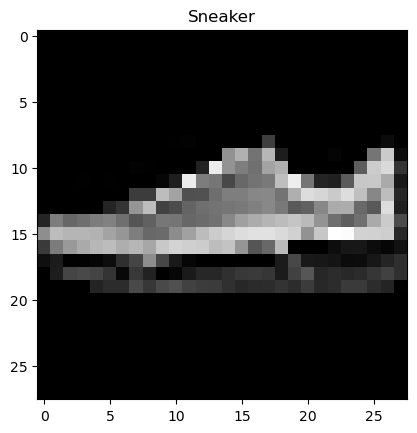

In [23]:
ix = 7 #Agarro el elemento numero 7
plt.imshow(X_test[ix].reshape(28,28), cmap="gray") #Reshape para acomodarlo en 28 * 28 (cuadrado)
plt.title(class_names[y_test[ix]]); #Le pone el nombre ... chequea que está bien (coincide el titulo con la imagen)

# Separamos en datos de desarrollo

Garantizamos que las clases siguen igualmente balanceadas (estratificación)

In [24]:
from sklearn.model_selection import train_test_split
X_newtrain, X_dev, y_newtrain, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train) # Test size = 20%, divide un quinto para reservar como desarrollo.
#Stratify garantiza que todo lo que metió en ese 20% tiene la misma cantidad de prendas de ropa que en el resto

np.bincount(y_newtrain), np.bincount(y_dev) #New Train = E , y_dev = Desarrollo

(array([400, 400, 400, 400, 400, 400, 400, 400, 400, 400]),
 array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))

# 1.KNN

### Implementación en Python

In [46]:
def distance(A, B):
    dot_product = A.dot(B)
    norm_product = np.linalg.norm(A) * np.linalg.norm(B)
    return 1 - (dot_product / norm_product)


#image set = lista de tuplas, con cada tupla = (imagen(vector), typo de imagen)
def image_distances(image_set, image):
    distances = []
    dis = 0
    for pic, label in image_set:
        dis = distance(image, pic)
        distances.append((dis, label))
    return distances

#distances = lista de tuplas, con cada tupla = (distancia de cada imagen de entrenamiento con la imagen elegida, typo de imagen)
def classify_image(distances, k):
    distances.sort(key=lambda x: x[0])
    number_of_apperances = np.zeros(10)
    for i in range(0, k): # k = cantidad de vecinos que queremos analizar 
       image_type = distances[i][1]
       number_of_apperances[image_type] = number_of_apperances[image_type] + 1  

    max = -1
    max_index = -1
    for i in range(0, len(number_of_apperances)):
        if(number_of_apperances[i] > max):
            max = number_of_apperances[i]
            max_index = i
    
    return max_index    

def knn_iterativo(image, images, images_types, k):
    image_set = zip(images, images_types)
    distances = image_distances(image_set, image)
    expected_type = classify_image(distances, k)
    return expected_type

# def first_test(image, image_type):
#     images = X_train[:4000]
#     types = y_train[:4000]
#     image_set = zip(images, types) #creamos las tuplas
#     distances = image_distances(image_set, image)
#     expected_type = classify_image(distances, 5)
#     return expected_type
#     # print(f"succes: {image_type == expected_type}; original type: {image_type}; expected type: {expected_type}")

expected_types = []
for i in range(4000, 5000):
    image = X_train[i]
    image_type = y_train[i]
    expected_types.append((knn_iterativo(image, X_train[:3999], y_train[:3999], 5), image_type))
print(expected_types)

KeyboardInterrupt: 

In [45]:
## A = prueba/desarrollo | B = entrenamiento
def distanceMatrix(A, B):   # Apilar verticalmente los vectores en una matriz
    # Calcular las normas de cada vector de las matrices A y B
    norms_a = np.linalg.norm(A, axis=1)
    norms_b = np.linalg.norm(B, axis=1)
    # Dividir cada componente de las matrices por la norma del vector correspondiente
    A_normalized = A / norms_a[:, np.newaxis]
    B_normalized = B / norms_b[:, np.newaxis]
    # Calcula la matriz traspuesta de B
    B_normalized_t = np.transpose(B_normalized)
    # Calcula la distancias haciendo una multiplicació n entre ambas matrices
    distances = A_normalized @ B_normalized_t
    # Hace 1 - distances
    # ones = np.ones((len(distances), len(distances)))
    distances = 1 - distances
    
    return distances

#######REVISAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAR ESTE IF NO ES LA MEJOR IMPLEMENTACION
## cambiar el if del delete por quedarme con las partes necesarias
def knn(k, distances_matrix, start_index_desarrollo, end_index_desarrollo):
    # Recorta la matriz segun nuestra conveniencia 
    sub_matrix = distances_matrix[start_index_desarrollo:end_index_desarrollo]
    # Eliminar las columnas desde col_start_index hasta col_end_index (inclusive col_end_index)
    #######REVISAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAR ESTE IF NO ES LA MEJOR IMPLEMENTACION
    if not(start_index_desarrollo == 0 and end_index_desarrollo == len(distances_matrix)):
        sub_matrix = np.delete(sub_matrix, np.s_[start_index_desarrollo:end_index_desarrollo], axis=1)
    # Ordena por distancias de más cercana a más lejana y hace módulo 10 
    sub_matrix = np.argsort(sub_matrix, axis=1) % 10
    # Se queda con las primeras k columnas más cercanas
    k_sub_matrix = sub_matrix[:, :k]
    # Calcula la moda 
    mode, frecuency = scipy.stats.mode(k_sub_matrix, axis=1)
    return mode

# print(len(knn(5,distanceMatrix(X_train, X_train),3000,4000)))


In [ ]:
#test matriz distancias
def second_test():
    distancias_clasica = np.zeros((5000, 5000))
    for i in range(0, 5000):
        for j in range(0, 5000): 
            distancias_clasica[i][j] = distance(X_train[i], X_train[j])
    return distancias_clasica


def son_iguales(distancias_clasica):
    distance_maitrx = distanceMatrix(X_train, X_train )
    matriz_de_comparacion = np.full((5000, 5000), False, dtype=bool)
    for i in range(0, 5000):
        for j in range(0, 5000):
            if np.isclose(distancias_clasica[i][j], distance_maitrx[i][j], atol=0.00001):
                matriz_de_comparacion[i][j] = True
    # print(distance_matrix)
    print(matriz_de_comparacion)

# second_test()
# old_distances = second_test()
# son_iguales(old_distances)

# 2.Método de la potencia

## a) Implementación del método de la potencia

### Compilamos los métodos en C++

In [26]:
import sys
sys.path.append('src')
# make clean
subprocess.run(['make', 'clean'], check=True)
# Ejecutar `make`
subprocess.run(['make'], check=True)
import metnum

def desglosar(resultados):
    return resultados[0], resultados[1], resultados[2], resultados[3]

rm -f src/metnum.cpython-312-x86_64-linux-gnu.so
g++ -O3 -Wall -shared -std=c++14 -fPIC -I/usr/include/python3.12 -I/usr/lib/python3.12/site-packages/pybind11/include -I/usr/include/python3.12 -I/usr/include/python3.12 -I/usr/include/eigen3 -o src/metnum.cpython-312-x86_64-linux-gnu.so src/metodos.cpp src/test_integration.cpp  -L/usr/lib  -ldl  -lm 


src/test_integration.cpp: In function ‘std::pair<std::pair<double, Eigen::Matrix<double, -1, 1> >, std::pair<double, int> > power_iteration(const Matrix&, unsigned int, double)’:
src/test_integration.cpp:7:34: warning: comparison of integer expressions of different signedness: ‘int’ and ‘unsigned int’ [-Wsign-compare]
    7 | #define forn(i, n) for(int i=0; i<n; i++)
      |                                  ^
src/test_integration.cpp:18:5: note: in expansion of macro ‘forn’
   18 |     forn(i, niter) {
      |     ^~~~


### Test para verificar la implementación

In [39]:

niter = 1000
def experimento_verificación(niter):
    reps = range(niter)
    D = np.diag([5, 4, 3, 2, 1]).astype(np.float64)  
    for r in range(0, niter):  
        v = 4*np.random.randn(D.shape[0], 1)
        v = v / np.linalg.norm(v)
        B = np.eye(D.shape[0]) - 2 * (v @ v.T) # Matriz de Householder
        M = B.T @ D @ B # Matriz a diagonalizar
        
        autovalores, autovectores, errors, iteraciones = desglosar(metnum.power_iteration_deflation(M,5, niter, 1e-7))
        print(autovectores)
        print(B.T)
        assert(np.allclose(autovalores, np.array([5, 4, 3, 2, 1]).astype(np.float64)))
        for j in range(0, len(autovectores)):
           print(j)
           assert(np.allclose(np.array(autovectores).T[j], B.T[j], atol=1e-6, rtol=1e-8) or (np.allclose(-1 * np.array(autovectores).T[j], B.T[j], atol=1e-6, rtol=1e-8)))
               
    return True

experimento_verificación(niter)

[[-0.53673209 -0.01286071  0.81608834 -0.15011052 -0.15238086]
 [ 0.01286097  0.99964297  0.02265544 -0.00416725 -0.00423028]
 [ 0.81608835 -0.02265564  0.43761348 -0.26443313 -0.26843268]
 [ 0.15011041 -0.00416723  0.26443317  0.95136043 -0.04937511]
 [ 0.15238084 -0.00423026  0.26843264 -0.0493753   0.94987798]]
[[ 0.53673209 -0.01286088 -0.81608836 -0.15011041 -0.15238084]
 [-0.01286088  0.99964297 -0.0226556  -0.00416725 -0.00423028]
 [-0.81608836 -0.0226556  -0.43761351 -0.26443308 -0.26843265]
 [-0.15011041 -0.00416725 -0.26443308  0.95136046 -0.04937521]
 [-0.15238084 -0.00423028 -0.26843265 -0.04937521  0.94987798]]
0
1
2
3
4
[[-0.557704   -0.07936159  0.75649667 -0.2817763  -0.17601961]
 [ 0.0793618   0.98576003  0.135739   -0.05055947 -0.03158342]
 [ 0.75649667 -0.13573918  0.29390095 -0.48194598 -0.30106139]
 [ 0.28177619 -0.05055943  0.481946    0.82048706 -0.11213802]
 [ 0.17601965 -0.03158341  0.30106145 -0.11213788  0.92994983]]
[[ 0.557704   -0.07936172 -0.75649668 -0.2

True

### b) Estudio de convergencia

In [77]:
def convergencia(niter):
    reps = range(niter)

    v_epsilon = np.logspace(-4, 0.68, endpoint=True)
    eigenvalues = ["10", "10-e", "5", "2", "1"]
    errors_global = []
    niters_global = []
    std_niters_global = []
    std_errors_global = []
    for e in v_epsilon:
        eigen_errors = []
        eigen_niters = []
       
        for r in reps:
            D = np.diag([10, 10-e, 5, 2, 1]).astype(np.float64)
            v = 4*np.random.randn(D.shape[0], 1)
            v = v / np.linalg.norm(v)
            
            # Matriz de Householder
            B = np.eye(D.shape[0]) - 2 * (v @ v.T)
            
            # Matriz a diagonalizar
            M = B.T @ D @ B
            l, V, errors, niters = desglosar(metnum.power_iteration_deflation(M,5, niter, 1e-7))

            eigen_errors.append(errors)
            eigen_niters.append(niters)
        mean_errors = np.mean(np.array(eigen_errors), axis=0)
        mean_niters = np.mean(np.array(eigen_niters), axis=0)
        
        std_errors = np.std(np.array(eigen_errors), axis=0)
        std_niters = np.std(np.array(eigen_niters), axis=0)

        errors_global.append(mean_errors)
        niters_global.append(mean_niters)
        std_errors_global.append(std_errors)
        std_niters_global.append(std_niters)
        
    
    errors_global = np.array(errors_global).T # lambda filas, epsilon columna
    niters_global = np.array(niters_global).T
    std_errors_global = np.array(std_errors_global).T
    std_niters_global = np.array(std_niters_global).T
    
    colors = ['b', 'g', 'r', 'c', 'm']
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    for i in range(5):
        axs[i].errorbar(v_epsilon, errors_global[i], yerr=std_errors_global[i], fmt='o', label="λ = " + eigenvalues[i], color=colors[i])
        axs[i].set_title(f'Error para λ = {eigenvalues[i]}')
        axs[i].set_xlabel("log(ε)")
        axs[i].set_ylabel("|| A v - λ v||2")
        axs[i].set_xscale('log')
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.savefig('error_metodo_deflacion.png')
    plt.show()

    # Crear subplots para iteraciones
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    for i in range(5):
        axs[i].errorbar(v_epsilon, niters_global[i], yerr=std_niters_global[i], fmt='o', label="λ = " + eigenvalues[i], color=colors[i])
        axs[i].set_title(f'Iteraciones para λ = {eigenvalues[i]}')
        axs[i].set_xlabel("log(ε)")
        axs[i].set_ylabel("Iteraciones")
        axs[i].set_xscale('log')
        axs[i].set_yscale('log')
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.savefig('iteraciones_metodo_deflacion.png')
    plt.show()

convergencia(1000000)

KeyboardInterrupt: 

# 3. Reconocimiento de imágenes en Fashion MNist
    

#### a - Realizar un reconocedor de imágenes usando KNN para un k fijo de 5, usando los datos de entrenamiento dados y medir la performance con la medida de exactitud en el conjunto de prueba. 

In [ ]:
def image_recognizer():
    # Calculamos las distancias entre las imágenes en X_ train y  X_test
    distances_matrix = distanceMatrix(X_test, X_train)
    # Hacemos KNN, siendo los elementos de prueba los que van de 5001 al 5500
    res_knn = knn(5,distances_matrix, 0, len(distances_matrix)) 

    # Para medir la performance, comparo el resultado de knn (modas) contra el resultado real (y_test)
    correctos = np.sum(res_knn == y_test) # Calcula la cantidad de elementos que son iguales en la misma posición
    performance = correctos / len(X_test)

    print("Predicciones correctas =", correctos)
    print("Performance =", performance)

image_recognizer()


Predicciones correctas = 417
Performance = 0.834


#### b - Explorar el hiperparámetro k, usando 5-fold cross-validation con el conjunto de entrenamiento

In [ ]:
def cross_validation(start_k, end_k, X_train):
    precomputo = distanceMatrix(X_train, X_train)
    averages = []
    for k in range (start_k,end_k): 
        performances = []
        for i in range (0,5):
            start = i*1000
            end = (i+1)*1000
            res_knn = knn(k, precomputo, start, end)
            # Calcula la cantidad de elementos calculados que coinciden con su tipo original
            correctos = np.sum(res_knn == y_train[start:end])
            # print(len(res_knn == y_train[start:end]))
            # print(correctos)
            performance = correctos / 1000
            performances.append(performance)
        average = np.mean(performances)
        averages.append(average)

    best_k_index = np.argmax(averages)
    #best_k = averages[best_k_index]
    return averages, best_k_index+1

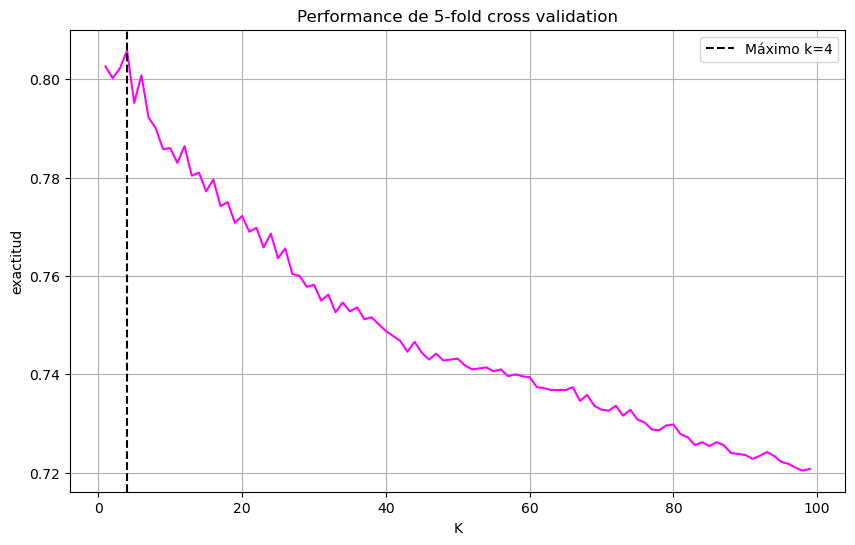

In [ ]:
def exploracion_hiperparametro(start_k, end_k, X_train):
    ks= np.arange(start_k, end_k)
    resultados, best_k= cross_validation(start_k, end_k, X_train)

    plt.figure(figsize=(10, 6))
    plt.plot(ks, resultados, color='fuchsia')
    plt.axvline(x=best_k, color='black', linestyle='--', label=f'Máximo k={best_k}')
    plt.title('Performance de 5-fold cross validation')
    plt.xlabel('K')
    plt.ylabel('exactitud')
    plt.grid(True)
    plt.legend()
    #plt.savefig('Performance 5_fold')
    plt.show()

##AGREGARLE PUNTITOS EN LOS VALORES Y LINEA PUNTEADA
#cross_validation(1, 10, X_train)
exploracion_hiperparametro(1,100, X_train)

#### c - Preprocesar los datos de entrenamiento con PCA. Visualizar la cantidad de varianza explicada en función de la cantidad de componentes p


In [41]:
def pca(dataset):
    # Se resta a cada valor la media de la imagen a la que pertenece (por fila)
    dataset_centered = dataset - np.mean(dataset, axis=1)[:, np.newaxis]
    # Se calcula la matriz de covarianza
    covariance_matrix = (dataset_centered.T @ dataset_centered)/ (len(dataset_centered[0])-1)
    print(covariance_matrix)
    # Encontrar autovalores y autovectores USANDO EL MÉTODO DE LA POTENCIA 
    l, V, errors, niters = desglosar(metnum.power_iteration_deflation(covariance_matrix, len(covariance_matrix[0]), niter, 1e-7))
   
    # V matriz de autovectores , D matriz de autovalores (ordenarlas por importancia)
    D = np.diag(l).astype(np.float64)
    # Reducir la dimensionalidad de los datos a p componentes = mult X_train por V utilizando los primeros p vectores columna de la matriz V
    V_p = np.array(V).T
    return V_p, D

# print(np.mean(X_train, axis=1)[:, np.newaxis])

def calculate_explaned_variance(D, p):
    # Calcular la varianza explicada en función de las p componentes   
    variance = 0
    for i in range(0,p):
       variance += D[i][i]
    cumulative_explained_variance = variance /np.trace(D)
    return cumulative_explained_variance


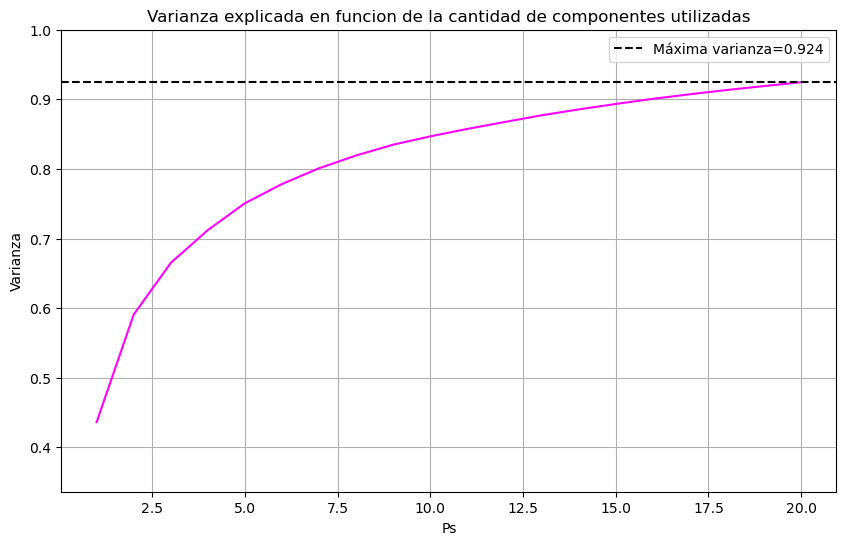

In [ ]:
variances = []
ps = []
for i in range(1, 21):
    ps.append(i)
    V, D = pca(X_train[:50])
    variances.append(calculate_explaned_variance(D, i))

plt.figure(figsize=(10, 6))
plt.plot(ps, variances, color='fuchsia')
# plt.axvline(x=best_k, color='black', linestyle='--', label=f'Máximo k={best_k}')
plt.axhline(y=max(variances), color='black', linestyle='--', label=f'Máxima varianza={str(max(variances))[:5]}')
plt.title('Varianza explicada en funcion de la cantidad de componentes utilizadas')
plt.xlabel('Ps')
plt.ylabel('Varianza')
plt.ylim(min(variances) - 0.1, 1)
plt.grid(True)
plt.legend()
#plt.savefig('varianza_explicada_pca')
plt.show()



#### d - Pipeline final: Exploración conjunta de los hiperparámetros k de KNN, y p de PCA.


In [42]:
pcas = []
niter = 1000

for i in range(0, 5):
    start_index_desarrollo = i*1000
    end_index_desarrollo = (i+1)*1000
    x_train = np.concatenate((X_train[0: start_index_desarrollo], X_train[end_index_desarrollo:]))
    V, D =  pca(x_train)
    pcas.append(V)


[[0.50248489 0.50238666 0.50201394 ... 0.47941764 0.49466711 0.50175205]
 [0.50238666 0.50230219 0.50197491 ... 0.47942943 0.49459708 0.50165382]
 [0.50201394 0.50197491 0.50182604 ... 0.47945348 0.49432677 0.5012811 ]
 ...
 [0.47941764 0.47942943 0.47945348 ... 0.48061571 0.48028613 0.47928979]
 [0.49466711 0.49459708 0.49432677 ... 0.48028613 0.4950029  0.49472905]
 [0.50175205 0.50165382 0.5012811  ... 0.47928979 0.49472905 0.50144223]]
[[0.50313308 0.50305821 0.50262603 ... 0.48125002 0.49675459 0.50237234]
 [0.50305821 0.50299601 0.50261183 ... 0.48128093 0.49670684 0.50229896]
 [0.50262603 0.50261183 0.50245373 ... 0.4813294  0.49642693 0.50190412]
 ...
 [0.48125002 0.48128093 0.4813294  ... 0.48393361 0.48232269 0.48115307]
 [0.49675459 0.49670684 0.49642693 ... 0.48232269 0.4963412  0.49680165]
 [0.50237234 0.50229896 0.50190412 ... 0.48115307 0.49680165 0.50205642]]
[[0.50345962 0.50341904 0.5031928  ... 0.4816554  0.49713418 0.50267497]
 [0.50341904 0.50337986 0.50315488 ... 

In [47]:

ks = np.arange(2, 11)
ps = np.arange(1, 31)
ps = np.append(ps, 784)

performances = []
for i in range(0, len(ks)):
    a = []
    for j in range(0, len(ps)):
        a.append([])
    performances.append(a)

for i in range (0, 5):
    start_index_desarrollo = i*1000
    end_index_desarrollo = (i+1)*1000
    x_dev = X_train[start_index_desarrollo:end_index_desarrollo]
    x_train = np.concatenate((X_train[0: start_index_desarrollo], X_train[end_index_desarrollo:]))
    # V, D =  pca(x_train)
    V = pcas[i] 
    for k in range(0, len(ks)):
        for p in range(0, len(ps)):
            x_hat_train = x_train @ V[:,:ps[p]]
            x_hat_dev = x_dev @ V[:,:ps[p]]
            distances = distanceMatrix(x_hat_dev, x_hat_train)
            res_knn = knn(ks[k], distances, 0, len(distances))
            exactitud = np.sum(res_knn == y_train[start_index_desarrollo:end_index_desarrollo]) / 1000
            performances[k][p].append(exactitud)


for k in range(0, len(ks)):
    for p in range(0, len(ps)):
            performances[k][p] = np.mean(performances[k][p])

indice_max = np.argmax(performances)

# Convertir el índice plano en un par de índices (fila, columna)
indice_max_fila_columna = np.unravel_index(indice_max, np.array(performances).shape)
print(str(indice_max_fila_columna[0] + 1) + ", " + str(indice_max_fila_columna[1]+ 1))
for i in range(len(performances)):
      print(performances[i])



3, 31
[0.1296, 0.2064, 0.2834, 0.335, 0.3962, 0.43620000000000003, 0.466, 0.49079999999999996, 0.5156000000000001, 0.5474, 0.5778, 0.5913999999999999, 0.6068, 0.6256, 0.6414, 0.6540000000000001, 0.6666000000000001, 0.681, 0.6854, 0.7032, 0.7125999999999999, 0.7186, 0.7203999999999999, 0.7226, 0.7226, 0.72, 0.7196, 0.72, 0.7234, 0.7249999999999999, 0.8]
[0.11399999999999999, 0.2212, 0.3014, 0.36, 0.4272, 0.4668, 0.49260000000000004, 0.5252000000000001, 0.5432, 0.5706, 0.5982, 0.6172, 0.6340000000000001, 0.6582000000000001, 0.6736000000000001, 0.685, 0.6988, 0.7045999999999999, 0.716, 0.727, 0.7308, 0.7372, 0.7384000000000001, 0.7402, 0.7355999999999999, 0.7388, 0.74, 0.7436, 0.7424000000000001, 0.7446, 0.8019999999999999]
[0.1302, 0.2318, 0.3156, 0.37700000000000006, 0.4378, 0.4888, 0.5002000000000001, 0.5286, 0.5559999999999999, 0.5804, 0.6106, 0.6228, 0.6414, 0.6656, 0.675, 0.6898000000000002, 0.7026, 0.7065999999999999, 0.7222, 0.7230000000000001, 0.7352, 0.735, 0.7345999999999999, 0

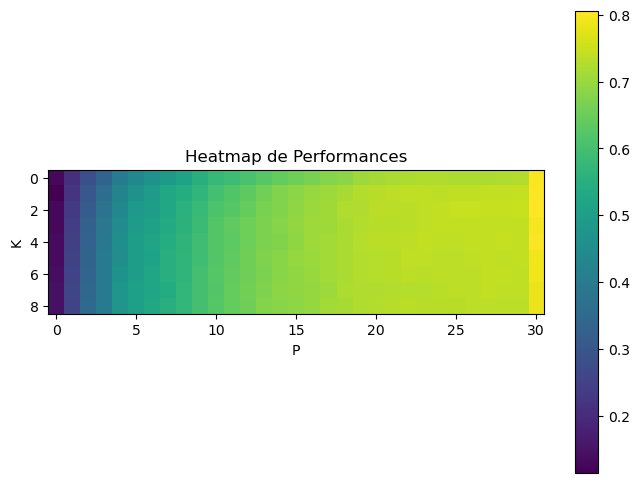

In [74]:
for i in range(0, 5):
    np.savetxt(f'pcas{i}.txt', pcas[i], fmt='%f')


plt.figure(figsize=(8, 6))
plt.imshow(performances, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap de Performances')
plt.xlabel('P')
plt.ylabel('K')
plt.show()

###### para un k fijo crafico la performance con distintos p

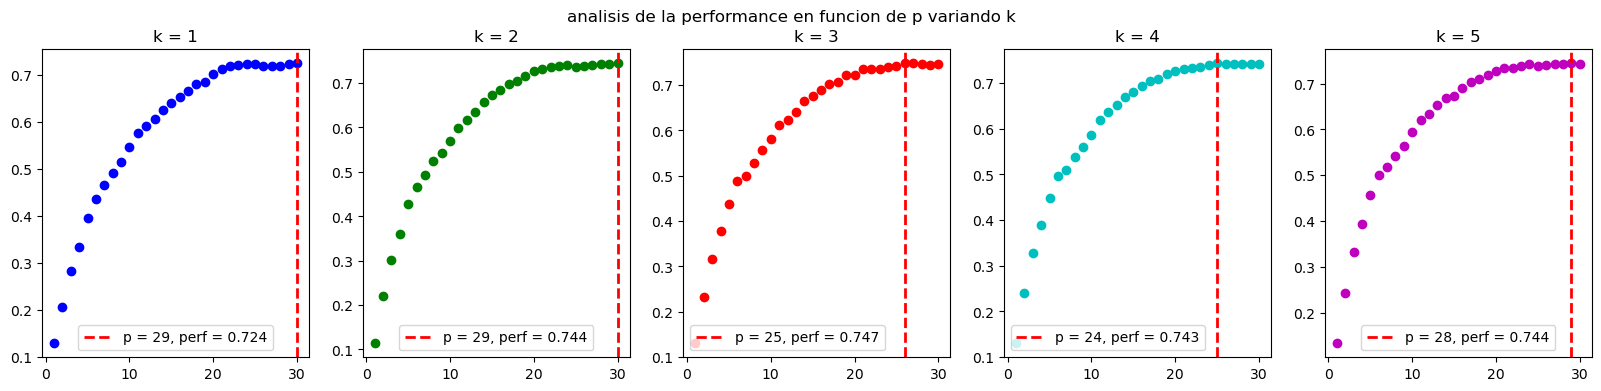

In [69]:
colors = ['b', 'g', 'r', 'c', 'm']
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
# Datos aleatorios para cada subgráfico
fig.suptitle("analisis de la performance en funcion de p variando k")


for i in range(5):
    index = performances[i][:len(ps)-1].index(max(performances[i][:len(ps)-1]))
    axs[i].scatter(ps[:len(ps)-1], performances[i][:len(ps)-1], color=colors[i])
    axs[i].set_title(f'k = {i + 1}')
    axs[i].axvline(x=ps[index], color='red', linestyle='--', linewidth=2, label = f"p = {index}, perf = {str(performances[i][index])[:5]}")
    axs[i].legend()

In [ ]:
def training_vs_test(best_k, best_p):
    # PCA sobre los datos de entrenamiento
    V, D = pca(X_train)
    # Reduccion de datos de entrenamiento a P componentes
    X_train_p = X_train @ V[:,best_p]
    # Distancias entre las imágenes en X_ test y  X_train_p
    distances_matrix = distanceMatrix(X_test, X_train_p)
    # KNN utilizando el best_k
    res_knn = knn(best_k, distances_matrix, 0, len(distances_matrix))
    # Medimos exactitud 
    correctos = np.sum(res_knn == y_test) # Calcula la cantidad de elementos que son iguales en la misma posición
    exactitud = correctos / len(X_test)

    print("Predicciones correctas =", correctos)
    print("Performance =", exactitud)

image_recognizer()


In [ ]:
print(X_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
